In [293]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [294]:
doses = [0.5, 1, 3, 5, 6] # From figure 6 and in units (mg/m^2 per day)
true_toxic_prob_s1 = (0.25, 0.3, 0.5, 0.6, 0.7) # Given by assignment instructions, scenario 1
true_toxic_prob_s2 = (0.01, 0.05, 0.2, 0.3, 0.5) # Given by assignment instructions, scenario 2

In [295]:
toxicity_observation = np.random.binomial(1, p=true_toxic_prob_s1[0], size=3) # first cohort, first dose
doses_observed = np.ones(3) * doses[0] # doses given to the three participants
data = pd.DataFrame({'doses':doses_observed, 'toxicity_event': toxicity_observation})
coords = {"observation": data.index.values}

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

with pm.Model(coords=coords) as logistic_regression_model:
    x = pm.ConstantData("doses", data['doses'], dims="observation")
    # priors
    beta0 = pm.Normal("beta0",mu=-2, sigma=2) # Made up by myself
    beta1 = pm.Exponential("beta1", lam=1) # given from the paper
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", sigmoid(mu), dims="observation")
    # likelihood
    y_obs = pm.Bernoulli("y", logit_p=mu, observed=data['toxicity_event'], dims="observation")
    # pm.Logistic("y", mu=mu, observed=data['toxicity_event'], dims="observation")
    

In [296]:
with logistic_regression_model:
    idata = pm.sample_prior_predictive(samples=3000, random_seed=rng)

Sampling: [beta0, beta1, y]


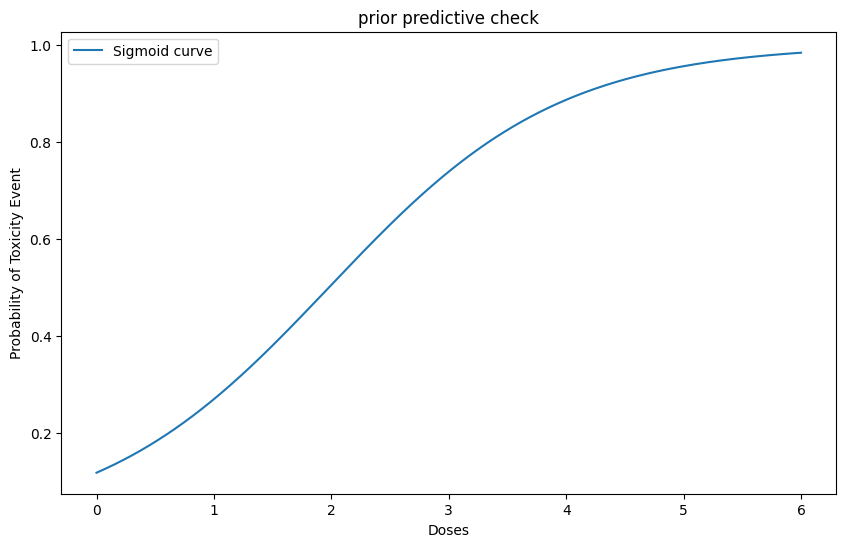

In [297]:
# Define a sigmoid function
def sigmoid(x, beta0, beta1):
    return 1 / (1 + np.exp(-(beta0 + beta1* x )))

# Extract betas from the trace
beta0 = np.mean(idata.prior['beta0'].values)
beta1 = np.mean(idata.prior['beta1'].values)

# Generate x values
x_values = np.linspace(0, max(doses), num=1000)

# Generate y values (sigmoid probabilities)
y_values = sigmoid(x_values, beta0, beta1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Sigmoid curve')
# plt.scatter(data['doses'], data['toxicity_event'], color='red', label='Data')
plt.xlabel('Doses')
plt.ylabel('Probability of Toxicity Event')
plt.title("prior predictive check")
plt.legend()

# Production Test

In [289]:
def sim_data(relevant_index):
    """ Simulates whether any of the 3 participants have a toxicity event given by the unknown probabilities.

    Args:
        relevant_index (Int): The index associated with the dose being used on the three samples.

    Returns:
        Pandas Dataframe: Contains the doses the three participants took and whether each participant had a toxicity event
    """
    toxicity_observation = np.random.binomial(1, p=true_toxic_prob_s1[relevant_index], size=3) # 3 samples per cohort
    doses_observed = np.ones(3) * doses[relevant_index] # doses given to the three participants
    # store data in a dataframe that will later be concatenated to make one dataframe
    data = pd.DataFrame({'doses':doses_observed, 'toxicity_event': toxicity_observation})
    return data


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def run_model(data):
    """ Creates a logistic regression model using the priors given in the paper
    and the data collected up until this point. 

    Args:
        data (Pandas Dataframe): Same dataframe given by sim_data()

    Returns:
        pymc model: Fitted model based on priors and the current data collected
    """
    coords = {"observation": data.index.values}
    with pm.Model(coords=coords) as logistic_regression_model:
        x = pm.ConstantData("doses", data['doses'], dims="observation")
        # priors
        beta0 = pm.Normal("beta0", mu=-2, sigma=2) # Made up by myself
        beta1 = pm.Exponential("beta1", lam=1) # given from the paper
        # linear model
        mu = beta0 + beta1 * x
        # probabilities
        p = pm.Deterministic("p", sigmoid(mu), dims="observation")
        # likelihood
        y_obs = pm.Bernoulli("y", logit_p=mu, observed=data['toxicity_event'], dims="observation") 
    return logistic_regression_model
    
    
def get_next_dose(idata):
    # Extract betas from the trace
    beta0 = np.mean(idata.posterior['beta0'].values)
    beta1 = np.mean(idata.posterior['beta1'].values)

    x_values = np.array(doses)
    # Generate y values (sigmoid probabilities)
    y_values = sigmoid(beta0 + beta1 * x_values)
    # select the highest dose that falls under the MTD threshold (0.33)
    next_dose = np.argmax(y_values[y_values <= 0.33])
    return next_dose

In [290]:
data = sim_data(2) # first run of the model
logistic_regression_model = run_model(data)
with logistic_regression_model:
    idata = pm.sample(3000, tune=3000, random_seed=rng)
next_dose = get_next_dose(idata)
print(next_dose)

# We already went through 3 samples out of 36. 36 // 3 = 12 - 1 = 11
for sample in range(20):
    new_data = sim_data(next_dose)
    data = pd.concat([data, new_data], axis=0, ignore_index=True)
    logistic_regression_model = run_model(data)
    with logistic_regression_model:
        idata = pm.sample(3000, tune=2000, random_seed=rng)
    next_dose = get_next_dose(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 2 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


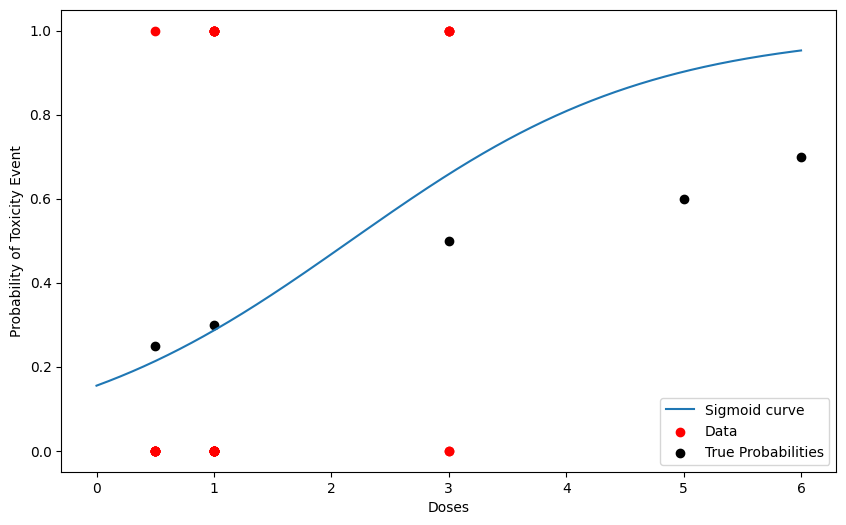

In [291]:
# Extract betas from the trace
beta0 = np.mean(idata.posterior['beta0'].values)
beta1 = np.mean(idata.posterior['beta1'].values)

# Define a sigmoid function
def sigmoid(x, beta0, beta1):
    return 1 / (1 + np.exp(-(beta0 + beta1* x )))

# Generate x values
x_values = np.linspace(0, max(doses), num=1000)

# Generate y values (sigmoid probabilities)
y_values = sigmoid(x_values, beta0, beta1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label='Sigmoid curve')
plt.scatter(data['doses'], data['toxicity_event'], color='red', label='Data')
plt.scatter(doses, true_toxic_prob_s1, color='black', label='True Probabilities')
plt.xlabel('Doses')
plt.ylabel('Probability of Toxicity Event')
plt.legend()

In [292]:
data

,doses,toxicity_event
0,3.0,1
1,3.0,0
2,3.0,0
3,3.0,1
4,3.0,1
5,3.0,1
6,1.0,0
7,1.0,1
8,1.0,0
9,1.0,0
